# AIR QUALITY

In [4]:
#establish connection
import os
import re
from sagemaker import get_execution_role

#define iam rle

role = get_execution_role()

## SET S3 BUCKET & UPLOAD LOCATION

In [5]:
#specify role and bucket
bucket = 'testing-lambda99'# s3 bucket where you will copy data and model artifacts
prefix = 'mra/air-quality' # place to upload training files within the bucket

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [8]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import sagemaker
import sagemaker.amazon.common as smac
import boto3

import warnings
warnings.filterwarnings("ignore")

### SET CONTAINER IMAGE

In [9]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

## DATA DESCRIPTION 

### Data Set Information:

#### The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 

#### This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded. 

#### Attribute Information:

#### 0 Date	(DD/MM/YYYY) 
#### 1 Time	(HH.MM.SS) 
#### 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
#### 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
#### 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
#### 5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
#### 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
#### 7 True hourly averaged NOx concentration in ppb (reference analyzer) 
#### 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
#### 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
#### 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
#### 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
#### 12 Temperature in Â°C	
#### 13 Relative Humidity (%) 
#### 14 AH Absolute Humidity 



##  DATA INGESTION

In [10]:
#download data file as csv
import boto3
import io

s3 = boto3.client('s3')

try:
    obj = s3.get_object(Bucket=bucket, Key='AirQualityUCI.csv')
    air = pd.read_csv(io.BytesIO(obj['Body'].read()),parse_dates=[['Date', 'Time']])
    print('Success: Data loaded into dataframe.')
    
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [11]:
#view for full screen
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.max_columns', 0)


## DATA INSPECTION

In [12]:
# print the shape of the data file
print("Datapoints in data sest",air.shape)

# show the top few rows
display("Top 5 rows",air.head())

Datapoints in data sest (9357, 14)


'Top 5 rows'

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [13]:
# Set Date time as Index
air.set_index('Date_Time', inplace=True)
air.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [14]:
air = air.loc[:,['T']]
air.rename(columns={'T': 'Temparature'}, inplace=True)
air.columns
air.head()

,Temparature
Date_Time,
2004-03-10 18:00:00,13.6
2004-03-10 19:00:00,13.3
2004-03-10 20:00:00,11.9
2004-03-10 21:00:00,11.0
2004-03-10 22:00:00,11.2


In [15]:
#nformation of the data
print('\nData Information\n')
air.info()


Data Information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 1 columns):
Temparature    9357 non-null float64
dtypes: float64(1)
memory usage: 146.2 KB


In [16]:
# statistical description of the data object
display("Statistical Description of data",air.describe())

'Statistical Description of data'

,Temparature
count,9357.000000
mean,9.778305
std,43.203623
min,-200.000000
25%,10.900000
50%,17.200000
75%,24.100000
max,44.600000


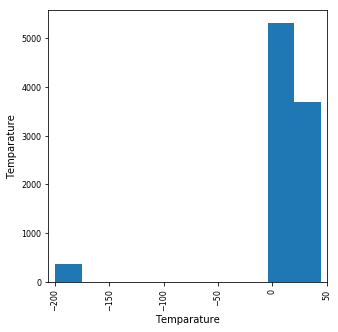

In [17]:
pd.plotting.scatter_matrix(air,figsize=(5, 5))
plt.show()

#Plot shows that there are some data points with temparature of -200 degrees which is not practically possible.
#Deleting these values

In [18]:
#Replace -200 values with mean of the value for Tempaature
air = air.replace(-200, np.nan)
print("Percentage missing data in each column \n",pd.isnull(air).sum())

Percentage missing data in each column 
 Temparature    366
dtype: int64


In [19]:
#replace Null values with Mean

# Mean value of each column
print("Mean values to be imputed with:",air.mean())

# Use Mean as imputation method for remaining missing data
air = air.fillna(air.mean())
print("\nPercent missing data",pd.isnull(air).sum())

Mean values to be imputed with: Temparature    18.317829
dtype: float64

Percent missing data Temparature    0
dtype: int64


## DATA VISUALIZATION

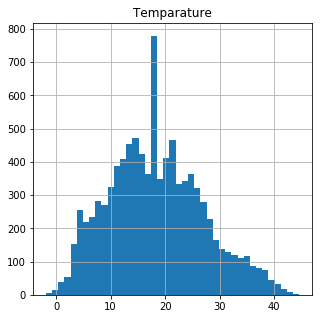

In [20]:
hist = air.hist(bins='auto',  figsize=(5, 5))

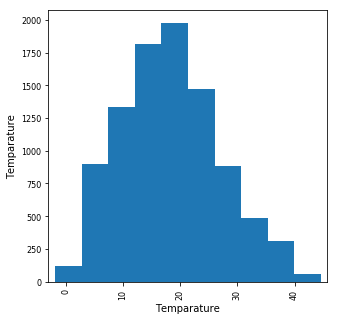

In [21]:
pd.plotting.scatter_matrix(air,figsize=(5, 5))
plt.show()

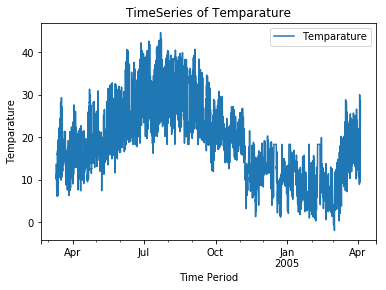

In [22]:
# PLot of TimeSeries
air.plot()
plt.xlabel("Time Period")
plt.ylabel("Temparature")
plt.title("TimeSeries of Temparature")
plt.show()

In [23]:
# Check frequency of Index
air.index

DatetimeIndex(['2004-03-10 18:00:00', '2004-03-10 19:00:00',
               '2004-03-10 20:00:00', '2004-03-10 21:00:00',
               '2004-03-10 22:00:00', '2004-03-10 23:00:00',
               '2004-03-11 00:00:00', '2004-03-11 01:00:00',
               '2004-03-11 02:00:00', '2004-03-11 03:00:00',
               ...
               '2005-04-04 05:00:00', '2005-04-04 06:00:00',
               '2005-04-04 07:00:00', '2005-04-04 08:00:00',
               '2005-04-04 09:00:00', '2005-04-04 10:00:00',
               '2005-04-04 11:00:00', '2005-04-04 12:00:00',
               '2005-04-04 13:00:00', '2005-04-04 14:00:00'],
              dtype='datetime64[ns]', name='Date_Time', length=9357, freq=None)

In [24]:
# As freq is None, set freq to hourly
air = air.asfreq('H')
air.index

DatetimeIndex(['2004-03-10 18:00:00', '2004-03-10 19:00:00',
               '2004-03-10 20:00:00', '2004-03-10 21:00:00',
               '2004-03-10 22:00:00', '2004-03-10 23:00:00',
               '2004-03-11 00:00:00', '2004-03-11 01:00:00',
               '2004-03-11 02:00:00', '2004-03-11 03:00:00',
               ...
               '2005-04-04 05:00:00', '2005-04-04 06:00:00',
               '2005-04-04 07:00:00', '2005-04-04 08:00:00',
               '2005-04-04 09:00:00', '2005-04-04 10:00:00',
               '2005-04-04 11:00:00', '2005-04-04 12:00:00',
               '2005-04-04 13:00:00', '2005-04-04 14:00:00'],
              dtype='datetime64[ns]', name='Date_Time', length=9357, freq='H')

### INTIALIZE VALUES FOR PREDICTION

In [26]:
# TimeSeries Requirement Assisnment

# Daily Granularity for TimeSeries
freq = 'H'

# Number of days in future to be predicted
prediction_length = 30

# Number of previous points to be considered before making prediction
context_length = 100

In [27]:
context_length

100

## CONVERT INTO TIME SERIES

In [28]:
#Convert dataframe to series

timeseries = []

for i in (range(air.shape[1])):
    timeseries.append(np.trim_zeros(air.iloc[:,i], trim='f'))

## TEST TRAIN SPLIT

In [29]:
# training set - all datapoints upto number of points to be predicted(set as prediction length)
# test set - entire dataset

time_series_training = []

for ts in timeseries:
    time_series_training.append(ts[:-prediction_length])

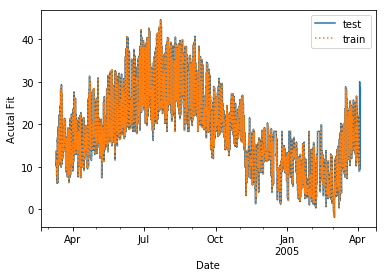

In [30]:
# plot of training set vs test Set
timeseries[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.xlabel("Date")
plt.ylabel("Acutal Fit")
plt.legend()
plt.show()

## DATA INTO JSON FOR DeepAR

In [31]:
# Convert data set into JSON format accpetable by DeepAR
# each time series just consists of a start time stamp (start) and a list of values (target)
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

# Convert dataset into JSON
def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [32]:
# Write JSON formats into S3 buckets
import s3fs

encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

# For train Set
with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

# For test set
with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in timeseries:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

## TRAIN DeepAR MODEL


In [33]:
# Configure training job
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='Temprature-deepar',
    output_path="s3://" + s3_output_path
)

In [34]:
# Set Hyperparameters for model
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [35]:
estimator.set_hyperparameters(**hyperparameters)

In [36]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: Temprature-deepar-2018-12-20-18-37-30-894


2018-12-20 18:37:31 Starting - Starting the training job...
2018-12-20 18:37:34 Starting - Launching requested ML instances......
2018-12-20 18:38:44 Starting - Preparing the instances for training......
2018-12-20 18:39:57 Downloading - Downloading input data
2018-12-20 18:39:57 Training - Downloading the training image....
Arguments: train
[12/20/2018 18:40:35 INFO 140298142705472] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[12/20/2018 18:40:35 INFO 140

## DEPLOY MODEL

In [37]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: Temprature-deepar-2018-12-20-18-37-30-894
INFO:sagemaker:Creating endpoint-config with name Temprature-deepar-2018-12-20-18-37-30-894
INFO:sagemaker:Creating endpoint with name Temprature-deepar-2018-12-20-18-37-30-894


---------------------------------------------------------------!

## PREDICTION

In [38]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

## PREDICTION AND RESULTS

In [39]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [40]:
pred = predictor.predict(time_series_training)
actual_data = timeseries

In [41]:
print(pred)

[                           0.1        0.5        0.9
2005-04-03 09:00:00  11.818872  13.527354  14.932798
2005-04-03 10:00:00  13.617298  15.594046  16.947283
2005-04-03 11:00:00  15.527637  17.445621  19.933735
2005-04-03 12:00:00  16.605581  19.022932  21.211796
2005-04-03 13:00:00  17.625618  20.130466  22.147966
2005-04-03 14:00:00  18.566860  21.043728  24.190502
2005-04-03 15:00:00  18.821465  21.148252  24.340752
2005-04-03 16:00:00  18.740152  21.074839  23.959711
2005-04-03 17:00:00  17.055029  20.203503  23.161938
2005-04-03 18:00:00  17.017385  19.199240  21.253321
2005-04-03 19:00:00  15.358176  17.683567  19.509041
2005-04-03 20:00:00  14.124889  16.163298  18.433353
2005-04-03 21:00:00  13.590608  15.528458  17.230806
2005-04-03 22:00:00  12.980351  14.883756  16.331640
2005-04-03 23:00:00  12.525997  14.399255  16.003204
2005-04-04 00:00:00  12.191152  13.894509  15.468498
2005-04-04 01:00:00  11.871284  13.644760  15.445626
2005-04-04 02:00:00  11.539585  13.132971  14

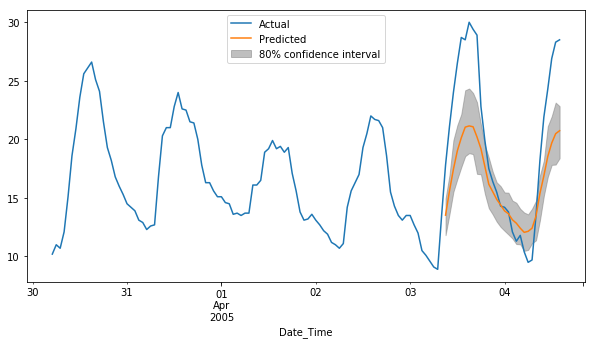

In [42]:
for i in range(len(pred)):
    plt.figure(figsize=(10,5))
    actual_data[i][-prediction_length-context_length:].plot(label='Actual')
    p10 = pred[i]['0.1']
    p90 = pred[i]['0.9']
    plt.fill_between(p10.index, p10, p90, color='grey', alpha=0.5, label='80% confidence interval')
    pred[i]['0.5'].plot(label='Predicted')
    pred_df=pd.DataFrame(pred[i]['0.5'])
    plt.legend()
    plt.show()

In [47]:
#Mean Squared Error
print("TEST RESULTS:")
print("Mean Squared Error",np.mean(np.subtract((air[-prediction_length:]), pred_df)**2))

#Median absolute percentage error
print("Median Absolute Percentage Error",
     np.median(np.abs(np.subtract((air[-prediction_length:]), pred_df)/air[-prediction_length:])))

TEST RESULTS:
Mean Squared Error Temparature    26.043942
dtype: float64
Median Absolute Percentage Error 0.23308827534511528


In [48]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: Temprature-deepar-2018-12-20-18-37-30-894
